# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print ("(Row, Column) : %s " % str(azdias.shape))
azdias.head()

(Row, Column) : (891221, 85) 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_nan_treated = azdias.copy()

for col in azdias_nan_treated:
    #get the dict for NaN
    nan_replacement_val = feat_info.loc[feat_info['attribute'] == col, 'missing_or_unknown'].values[0]
    try:
        nan_replacer_list = pd.eval(nan_replacement_val)
    except:
        nan_replacer_list = nan_replacement_val.replace("[", "").replace("]", "").split(",")
        
    if len(nan_replacer_list) > 0:
        azdias_nan_treated[col].replace(to_replace=nan_replacer_list, value=np.nan, \
                 inplace=True)        
    
    #check if all necessary values had been mapped to NaN
    assert (len(azdias_nan_treated[azdias_nan_treated[col].isin(nan_replacer_list)]) == 0), "Some values not mapped to NaN properly!"


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# calc ratio of NaN for each feature
num_rows_azdias = azdias_nan_treated.shape[0]
azdias_nan_ratio = azdias_nan_treated.isna().sum()/num_rows_azdias
azdias_nan_ratio_sorted = azdias_nan_ratio.sort_values(ascending=False)
df_azdias_nan = azdias_nan_ratio_sorted.reset_index()
df_azdias_nan = df_azdias_nan.rename(columns={'index': 'feature', 0: 'nan_ratio'})

#display the top 10 columns with the highest number of NaN data in descending order
df_azdias_nan.head(n=10)

,feature,nan_ratio
0,TITEL_KZ,0.997576
1,AGER_TYP,0.769554
2,KK_KUNDENTYP,0.655967
3,KBA05_BAUMAX,0.534687
4,GEBURTSJAHR,0.440203
5,ALTER_HH,0.348137
6,REGIOTYP,0.177357
7,KKK,0.177357
8,W_KEIT_KIND_HH,0.166051
9,KBA05_ANTG4,0.149597


Text(0, 0.5, 'Number of columns')

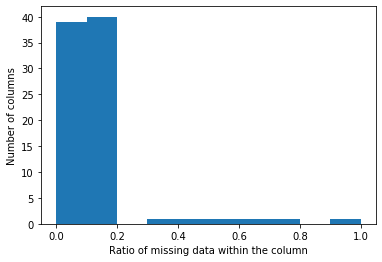

In [7]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(x=df_azdias_nan['nan_ratio'])
plt.xlabel('Ratio of missing data within the column')
plt.ylabel('Number of columns')

In [8]:
#calc mean and std dev of NaN ratio
print ("Mean of NaN ratio : %f" % df_azdias_nan['nan_ratio'].mean())
print ("Std dev of NaN ratio : %f" % df_azdias_nan['nan_ratio'].std())
#use 1 standard deviation as a cut-off point
outlier_threshold = df_azdias_nan['nan_ratio'].mean() + df_azdias_nan['nan_ratio'].std()
print ("Outlier threshold : %f" % outlier_threshold)

Mean of NaN ratio : 0.110541
Std dev of NaN ratio : 0.164498
Outlier threshold : 0.275040


From the histogram above, we can see most of the columns have a ratio of NaN of less than 0.2. We can say that outliers are columns with NaN ratio **above 0.275040**.

In [9]:
num_outlier_azdias = len(df_azdias_nan[df_azdias_nan['nan_ratio'] > outlier_threshold])

print ("Number of outlier columns = %i" % (num_outlier_azdias))
print ("Percentage of outlier columns = %f %%" % (100 * num_outlier_azdias / len(df_azdias_nan) ))

Number of outlier columns = 6
Percentage of outlier columns = 7.058824 %


In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

features_to_remove = df_azdias_nan.loc[df_azdias_nan['nan_ratio'] > outlier_threshold, 'feature']
features_to_keep = df_azdias_nan.loc[df_azdias_nan['nan_ratio'] <= outlier_threshold, 'feature']

print ("The columns to be dropped are:")
print (features_to_remove)

The columns to be dropped are:
0        TITEL_KZ
1        AGER_TYP
2    KK_KUNDENTYP
3    KBA05_BAUMAX
4     GEBURTSJAHR
5        ALTER_HH
Name: feature, dtype: object


In [11]:
#sanity check to see if indeed these columns have a lot of NaN
azdias_nan_treated[features_to_remove].head(n=10)

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,5.0,1996.0,NaN
2,NaN,NaN,NaN,NaN,1979.0,17.0
3,NaN,2.0,NaN,1.0,1957.0,13.0
4,NaN,NaN,1.0,NaN,1963.0,20.0
5,NaN,3.0,3.0,NaN,1943.0,10.0
6,NaN,NaN,NaN,1.0,NaN,NaN
7,NaN,NaN,NaN,NaN,1964.0,14.0
8,NaN,NaN,NaN,NaN,1974.0,16.0
9,NaN,NaN,6.0,NaN,1975.0,17.0


In [12]:
azdias_nan_treated[features_to_keep].head(n=10)

,REGIOTYP,KKK,W_KEIT_KIND_HH,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,PLZ8_GBZ,...,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ZABEOTYP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,3,3,4,7,6,6,5,3,3
1,3.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,4.0,...,2,2,3,6,4,7,4,7,6,5
2,2.0,2.0,3.0,0.0,3.0,3.0,1.0,3.0,1.0,4.0,...,4,6,3,4,7,7,7,3,3,5
3,NaN,NaN,NaN,0.0,4.0,4.0,4.0,1.0,0.0,4.0,...,4,7,4,3,4,4,5,4,4,3
4,5.0,3.0,2.0,0.0,3.0,3.0,1.0,4.0,1.0,3.0,...,4,4,6,2,3,2,2,4,2,4
5,5.0,4.0,6.0,0.0,4.0,4.0,2.0,2.0,0.0,5.0,...,2,2,5,7,4,4,4,7,6,4
6,5.0,3.0,3.0,0.0,3.0,5.0,3.0,2.0,0.0,5.0,...,6,5,5,7,7,4,7,7,7,4
7,1.0,1.0,5.0,0.0,4.0,4.0,2.0,2.0,0.0,4.0,...,2,2,7,5,1,1,2,5,5,1
8,3.0,1.0,5.0,0.0,5.0,3.0,1.0,1.0,0.0,3.0,...,6,4,5,2,5,5,3,1,4,6
9,1.0,1.0,4.0,0.0,2.0,3.0,1.0,3.0,1.0,3.0,...,6,6,3,4,7,6,7,1,3,4


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**: From the histogram above, we can see most of the columns have a ratio of missing data or NaN of less than the threshold of 0.2. There are 6 columns which are outliers. The columns to remove are

Outlier | Description | Comment
--- | --- | ---
`TITEL_KZ` | Academic title flag | Not surprising as this info is only applicable to academicians, a small subset of population
`AGER_TYP` | Best-ager topology| Difficulty in classification may have led to high proportion of missing data
`KK_KUNDENTYP` | Consumer pattern over past 12 months | Not surprising as not everyone are consumers from the mail-order company
`KBA05_BAUMAX` | Number of 1-2 family houses in the microcell | Nil comment
`GEBURTSJAHR` | Year of birth | It's surprising that this info has high proportion of missing data
`ALTER_HH` | Birthdate of head of household | It's surprising that this info has high proportion of missing data


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5, 0, 'Ratio of missing data in the row')

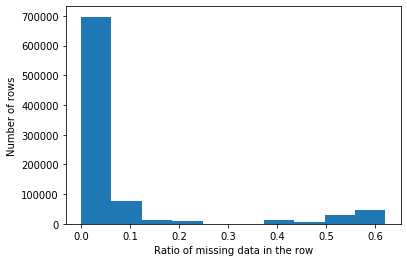

In [13]:
# How much data is missing in each row of the dataset?

azdias_dataset = azdias_nan_treated.drop(columns=features_to_remove)

num_azdias_column = azdias_dataset.shape[1]

row_nan_ratio = azdias_dataset.isna().sum(axis=1)/num_azdias_column

#Visualise in histogram

plt.hist(row_nan_ratio)
plt.ylabel('Number of rows')
plt.xlabel('Ratio of missing data in the row')

In [14]:
#calc mean and std dev of NaN ratio
print ("Mean of NaN ratio : %f" % row_nan_ratio.mean())
print ("Std dev of NaN ratio : %f" % row_nan_ratio.std())
row_outlier_threshold = row_nan_ratio.mean() + row_nan_ratio.std()
print ("Row Outlier Threshold : %f" % row_outlier_threshold)

Mean of NaN ratio : 0.071518
Std dev of NaN ratio : 0.167528
Row Outlier Threshold : 0.239045


Visually, we can see two distinct subsets of data with different ratios of missing data. One group clusters below 0.2, while the other clusters around 0.4 and above. We can pick ratio = 0.239 as threshold, using mean + 1 std .

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_dataset_bad = azdias_dataset[row_nan_ratio > row_outlier_threshold]
azdias_dataset_good = azdias_dataset[row_nan_ratio <= row_outlier_threshold]

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Choose the 5 columns with the lowest ratio of NaN, using previous analysis
columns_good = df_azdias_nan.tail()['feature']

print (columns_good)

80        SEMIO_DOM
81       SEMIO_KAEM
82    SEMIO_PFLICHT
83      SEMIO_TRADV
84         ZABEOTYP
Name: feature, dtype: object


Text(0.5, 0.98, 'Comparison of the distribution between the good subset (left) and bad subset (right)')

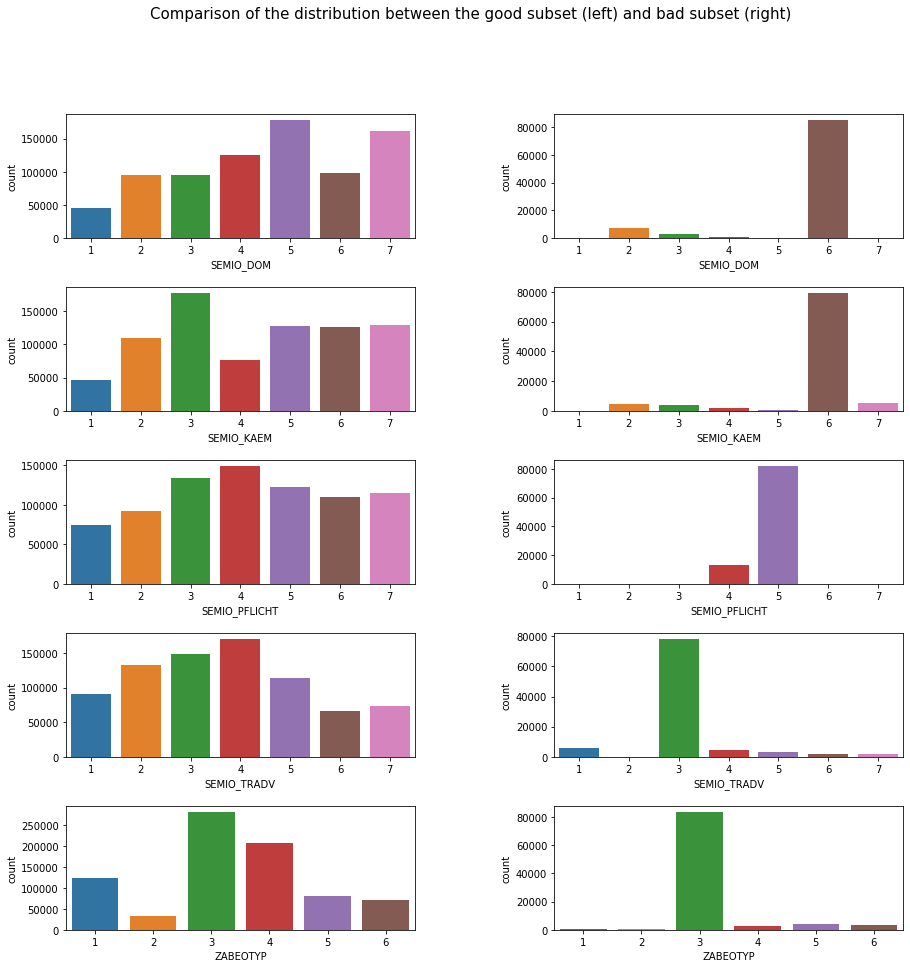

In [17]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

num_row_subplot = len(columns_good)

for index in range(0, len(columns_good)):
    feature = columns_good.iloc[index]
    index = index + 1
    ax = fig.add_subplot(num_row_subplot, 2, (index * 2 - 1))
    sns.countplot(x=feature, data=azdias_dataset_good)
    ax = fig.add_subplot(num_row_subplot, 2, index * 2)
    sns.countplot(x=feature, data=azdias_dataset_bad)
    
fig.suptitle('Comparison of the distribution between the good subset (left) and bad subset (right)', fontsize=15)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer:** Yes, the two subsets look distinctly different. For the good subset, it appears that the distribution of values within the columns are more evenly distributed. For the bad subset, the distribution of value tends to be skewed and concentrated on one or two values. We should drop the bad subset, as skewed sample data is not suitable for analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?

data_type = feat_info['type'].unique()

for type in data_type:
    n_type = len(feat_info[feat_info['type'] == type])
    print (n_type, type)

21 categorical
49 ordinal
7 numeric
7 mixed
1 interval


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

features_categorical = feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
features_to_encode = features_categorical.copy()
print (features_to_encode)

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


Upon inspection of `Data_Dictionary.md`, we see that the following features (rough version) are redundant, as the more detailed version of data (fine version) is already part of the list. The features below can therefore be dropped.

* `LP_FAMILIE_GROB`
* `LP_STATUS_GROB`
* `CAMEO_DEUG_2015`

In [20]:
#add to list of features to be removed
append_list = pd.Series(name='feature', data=['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'])
features_to_remove = features_to_remove.append(append_list, ignore_index=True)

In [21]:
features_to_remove

0           TITEL_KZ
1           AGER_TYP
2       KK_KUNDENTYP
3       KBA05_BAUMAX
4        GEBURTSJAHR
5           ALTER_HH
6    LP_FAMILIE_GROB
7     LP_STATUS_GROB
8    CAMEO_DEUG_2015
Name: feature, dtype: object

In [22]:
for index, feature in features_to_encode.iteritems():
    if feature in features_to_remove.values:
        print ("Drop feature from list to encode: %s" % feature)
        features_to_encode.drop(index, inplace=True)

Drop feature from list to encode: AGER_TYP
Drop feature from list to encode: LP_FAMILIE_GROB
Drop feature from list to encode: LP_STATUS_GROB
Drop feature from list to encode: TITEL_KZ
Drop feature from list to encode: KK_KUNDENTYP
Drop feature from list to encode: CAMEO_DEUG_2015


In [23]:
#drop binary columns that need not be encoded 

features_to_encode = features_to_encode.reset_index(drop=True)

for index, feature in features_to_encode.iteritems():
    unique_values = azdias_nan_treated[feature].dropna().unique()
    if len(unique_values) == 2 and unique_values.dtype != 'object':
        print ("Drop binary feature from list to encode: %s" % feature)
        features_to_encode.drop(index, inplace=True)

Drop binary feature from list to encode: ANREDE_KZ
Drop binary feature from list to encode: GREEN_AVANTGARDE
Drop binary feature from list to encode: SOHO_KZ
Drop binary feature from list to encode: VERS_TYP


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
# List of multi-level categories columns that need to be encoded using dummy variables
# We will remove some of the features based on `features_to_remove` list later
print ("List of features to encode:")
print (features_to_encode)

List of features to encode:
1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
5      LP_FAMILIE_FEIN
6       LP_STATUS_FEIN
7     NATIONALITAET_KZ
8          SHOPPER_TYP
11            ZABEOTYP
12         GEBAEUDETYP
13         OST_WEST_KZ
14      CAMEO_DEU_2015
Name: attribute, dtype: object


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**: 

We removed the following binary features (numerical) from the list to be encoded:

* `ANREDE_KZ`
* `GREEN_AVANTGARDE`
* `SOHO_KZ`

In addition, we also have to remove columns which are redundant and have high NaN ratio as loaded in `features_to_remove` list

The list of features to be encoded (at this point of time) are

*        `CJT_GESAMTTYP`
*            `FINANZTYP`
*      `GFK_URLAUBERTYP`
*      `LP_FAMILIE_FEIN`
*       `LP_STATUS_FEIN`
*     `NATIONALITAET_KZ`
*          `SHOPPER_TYP`
*            `VERS_TYP`
*            `ZABEOTYP`
*         `GEBAEUDETYP`
*         `OST_WEST_KZ`
*      `CAMEO_DEU_2015`

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#create dict for mapping of values
"""
new variable to use the following encoding:
- NaN: unknown
-  1: 1940s
-  2: 1950s
-  3: 1960s
-  4: 1970s
-  5: 1980s
-  6: 1990s
"""
decade_map_dict = {-1:np.nan, 0:np.nan, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5,
                     11:5, 12:5, 13:5, 14:6, 15: 6}

#create a new feature of 'interval' type capturing 'Decade' info
azdias_dataset_good['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_dataset_good['PRAEGENDE_JUGENDJAHRE'].replace(decade_map_dict)
azdias_dataset_good['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6.0    224807
4.0    174841
5.0    151442
3.0    114236
2.0     74198
1.0     28088
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [26]:
#create dict for mapping of values
"""
new variable to use the following encoding:
- NaN: unknown
-  1: mainstream
-  2: avantgarden
"""
movement_map_dict = {-1:np.nan, 0:np.nan, 1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1,
                     11:2, 12:1, 13:2, 14:1, 15: 2}

#create a new feature of 'binary' type capturing 'Movement' info
azdias_dataset_good['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_dataset_good['PRAEGENDE_JUGENDJAHRE'].replace(movement_map_dict)
azdias_dataset_good['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts()

/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1.0    592723
2.0    174889
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# pos=0 for household wealth, pos=1 for life stage
def map_cameo(input, pos):
    if pd.isna(input):
        return input
    else:
        return str(input)[pos]

azdias_dataset_good['CAMEO_HOUSEHOLD_WEALTH'] = azdias_dataset_good['CAMEO_INTL_2015'].apply(map_cameo, pos=0)
azdias_dataset_good['CAMEO_LIFE_STAGE'] = azdias_dataset_good['CAMEO_INTL_2015'].apply(map_cameo, pos=1)

/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [28]:
#check for other mixed types
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


`LP_LEBENSPHASE_GROB` is a rough version of `LP_LEBENSPHASE_FEIN`, and therefore we can drop `LP_LEBENSPHASE_GROB` as it is redundant. This is in addition to  `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`

In [29]:
features_to_encode

1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
5      LP_FAMILIE_FEIN
6       LP_STATUS_FEIN
7     NATIONALITAET_KZ
8          SHOPPER_TYP
11            ZABEOTYP
12         GEBAEUDETYP
13         OST_WEST_KZ
14      CAMEO_DEU_2015
Name: attribute, dtype: object

In [30]:
append_list = pd.Series(name='attribute', data=['LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])
features_to_remove = features_to_remove.append(append_list, ignore_index=True)

In [31]:
features_to_remove

0                  TITEL_KZ
1                  AGER_TYP
2              KK_KUNDENTYP
3              KBA05_BAUMAX
4               GEBURTSJAHR
5                  ALTER_HH
6           LP_FAMILIE_GROB
7            LP_STATUS_GROB
8           CAMEO_DEUG_2015
9       LP_LEBENSPHASE_GROB
10    PRAEGENDE_JUGENDJAHRE
11          CAMEO_INTL_2015
dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features

**Answer**: We created 4 new variables `PRAEGENDE_JUGENDJAHRE_MOVEMENT`, `PRAEGENDE_JUGENDJAHRE_DECADE`, `CAMEO_HOUSEHOLD_WEALTH` and `CAMEO_LIFE_STAGE`, which replaced `PRAEGENDE_JUGENDJAHRE`, `CAMEO_INTL_2015`.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#remove columns that are loaded in `features_to_remove`
for index, feature in features_to_encode.iteritems():
    if feature in features_to_remove.values:
        print ("Drop feature from list to encode: %s" % feature)
        features_to_encode.drop(index, inplace=True)

In [33]:
#this is the final list of features to be encoded for the good subset 
features_to_encode

1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
5      LP_FAMILIE_FEIN
6       LP_STATUS_FEIN
7     NATIONALITAET_KZ
8          SHOPPER_TYP
11            ZABEOTYP
12         GEBAEUDETYP
13         OST_WEST_KZ
14      CAMEO_DEU_2015
Name: attribute, dtype: object

In [34]:
#this is the final list of features to be removed from the good subset
features_to_remove

0                  TITEL_KZ
1                  AGER_TYP
2              KK_KUNDENTYP
3              KBA05_BAUMAX
4               GEBURTSJAHR
5                  ALTER_HH
6           LP_FAMILIE_GROB
7            LP_STATUS_GROB
8           CAMEO_DEUG_2015
9       LP_LEBENSPHASE_GROB
10    PRAEGENDE_JUGENDJAHRE
11          CAMEO_INTL_2015
dtype: object

In [35]:
for feature in azdias_dataset_good.columns:
    if feature in features_to_remove.values:
        print ("Drop feature from good subset: %s" % feature)
        azdias_dataset_good.drop(columns=feature, inplace=True)

Drop feature from good subset: LP_LEBENSPHASE_GROB


/Users/songhanwong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Drop feature from good subset: LP_FAMILIE_GROB
Drop feature from good subset: LP_STATUS_GROB
Drop feature from good subset: PRAEGENDE_JUGENDJAHRE
Drop feature from good subset: CAMEO_DEUG_2015
Drop feature from good subset: CAMEO_INTL_2015


In [36]:
#perform encoding for the final dataset, for selected features
azdias_dataset_good = pd.get_dummies(columns=features_to_encode, data=azdias_dataset_good)

In [37]:
#final set of clean data
azdias_dataset_good.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
customers_df = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
azdias_df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

In [39]:
def map_cameo(input, pos):
    if pd.isna(input):
        return input
    else:
        return str(input)[pos]

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the feature summary file.
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")   
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_nan_treated = df.copy()

    for col in df_nan_treated:
        #get the dict for NaN
        nan_replacement_val = feat_info.loc[feat_info['attribute'] == col, 'missing_or_unknown'].values[0]
        try:
            nan_replacer_list = pd.eval(nan_replacement_val)
        except:
            nan_replacer_list = nan_replacement_val.replace("[", "").replace("]", "").split(",")

        if len(nan_replacer_list) > 0:
            df_nan_treated[col].replace(to_replace=nan_replacer_list, value=np.nan, \
                     inplace=True)        

        #check if all necessary values had been mapped to NaN
        assert (len(df_nan_treated[df_nan_treated[col].isin(nan_replacer_list)]) == 0), "Some values not mapped to NaN properly!"

    
    # remove selected columns and rows, ...
    
    # This section removes columns with high NaN ratio
    # calc ratio of NaN
    num_rows_df = df_nan_treated.shape[0]
    df_nan_ratio = df_nan_treated.isna().sum()/num_rows_df
    df_nan_ratio = df_nan_ratio.sort_values(ascending=False)
    df_nan_ratio = df_nan_ratio.reset_index()
    df_nan_ratio = df_nan_ratio.rename(columns={'index': 'feature', 0: 'nan_ratio'})

    #use mean + 1 std as threshold
    outlier_threshold = df_nan_ratio['nan_ratio'].mean() + df_nan_ratio['nan_ratio'].std()
    num_outlier = len(df_nan_ratio[df_nan_ratio['nan_ratio'] > outlier_threshold])
    print ("Number of outlier columns = %i" % (num_outlier))
    print ("Percentage of outlier columns = %f %%" % (100 * num_outlier / len(df_nan_ratio) ))    
    
    #add to list of features to be removed
    features_to_remove = df_nan_ratio.loc[df_nan_ratio['nan_ratio'] > outlier_threshold, 'feature']
    
    # This section removes rows with high NaN ratio
    # calc ratio of NaN    
    df_nan_treated.drop(columns=features_to_remove, inplace=True)
    num_column = df_nan_treated.shape[1]
    row_nan_ratio = df_nan_treated.isna().sum(axis=1)/num_column

    #use mean + 1 std as threshold
    row_outlier_threshold = row_nan_ratio.mean() + row_nan_ratio.std()
    print ("Row Outlier Threshold : %f" % row_outlier_threshold)

    #only take the rows below the NaN threshold
    df_dataset_good = df_nan_treated[row_nan_ratio <= row_outlier_threshold]
    
    # select, re-encode, and engineer column values.
    # load initial list of features to be encoded from categorical data
    features_categorical = feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
    features_to_encode = features_categorical.copy()
    
    #remove redundant features from categorical data
    append_list = pd.Series(name='feature', data=['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'])
    features_to_remove = features_to_remove.append(append_list, ignore_index=True)

    #remove unwanted features
    for index, feature in features_to_encode.iteritems():
        if feature in features_to_remove.values:
            features_to_encode.drop(index, inplace=True)
            
    #drop binary columns that need not be encoded 
    features_to_encode = features_to_encode.reset_index(drop=True)
    
    for index, feature in features_to_encode.iteritems():
        unique_values = df_nan_treated[feature].dropna().unique()
        if len(unique_values) == 2 and unique_values.dtype != 'object':
            features_to_encode.drop(index, inplace=True)
    #special handlers for 'PRAEGENDE_JUGENDJAHRE' feature
    
    #dict for mapping of original values to new features of 'interval' type
    decade_map_dict = {-1:np.nan, 0:np.nan, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5,
                         11:5, 12:5, 13:5, 14:6, 15: 6}
    movement_map_dict = {-1:np.nan, 0:np.nan, 1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1,
                         11:2, 12:1, 13:2, 14:1, 15: 2}

    #create a new variable for the new map 
    df_dataset_good['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_dataset_good['PRAEGENDE_JUGENDJAHRE'].replace(decade_map_dict)
    df_dataset_good['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_dataset_good['PRAEGENDE_JUGENDJAHRE'].replace(movement_map_dict)
 
    #special handler for 'CAMEON_INTL_2015' feature
    df_dataset_good['CAMEO_HOUSEHOLD_WEALTH'] = df_dataset_good['CAMEO_INTL_2015'].apply(map_cameo, pos=0)
    df_dataset_good['CAMEO_LIFE_STAGE'] = df_dataset_good['CAMEO_INTL_2015'].apply(map_cameo, pos=1)

    #append new features created to list of features to be encoded
    mixed_append_list = pd.Series(name='feature', data=['PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE_DECADE', \
                                              'CAMEO_HOUSEHOLD_WEALTH', 'CAMEO_LIFE_STAGE'])
    features_to_encode = features_to_encode.append(mixed_append_list, ignore_index=True)   
    
    #append all the 'mixed' type of features to the list of features to be encoded
    features_to_encode = features_to_encode.append(feat_info.loc[feat_info['type'] == 'mixed', 'attribute'])

    #append redundant features to the list of features to be removed 
    append_list = pd.Series(name='attribute', data=['LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])
    features_to_remove = features_to_remove.append(append_list, ignore_index=True)
        
    #remove any unwanted features from the list for encoding later
    for index, feature in features_to_encode.iteritems():
        if feature in features_to_remove.values:
            features_to_encode.drop(index, inplace=True)        

    #remove unwanted features from good subset of dataset
    for feature in df_dataset_good.columns:
        if feature in features_to_remove.values:
            df_dataset_good.drop(columns=feature, inplace=True)
            
    #encode all the necessary features
    df_dataset_good = pd.get_dummies(columns=features_to_encode, data=df_dataset_good)    
    
    # Return the cleaned dataframe.
    return df_dataset_good

In [40]:
customer_df_clean = clean_data(customers_df.copy())
azdias_df_clean = clean_data(azdias_df.copy())

Number of outlier columns = 5
Percentage of outlier columns = 5.882353 %
Row Outlier Threshold : 0.415780


/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Number of outlier columns = 6
Percentage of outlier columns = 7.058824 %
Row Outlier Threshold : 0.239045


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# calc percentage of rows with at least one missing feature

perc_row_na = 100 - 100 * len(azdias_df_clean.dropna())/len(azdias_df_clean) 
print ("Percentage of rows with at least one missing feature: %s %%" % perc_row_na)

Percentage of rows with at least one missing feature: 20.576908821116305 %


The percentage is quite high, about 20.6%! We cannot just remove all these rows. But let's calculate the scaling parameters in the event if we do so.

In [42]:
from sklearn import impute

def impute_feature(df):
    """
    Perform imputation on missing values.
    
    For 'ordinal', 'interval' and 'categorical' feature, we use 'most_frequent' as strategy
    For 'numeric' feature, we use 'mean' as strategy
    
    INPUT: Demographics DataFrame
    OUTPUT: Demographics DataFrame where missing values are imputed
    """    

    for feature in df.columns:
        feature_attribute = feat_info.loc[feat_info['attribute'] == feature, 'type'].values
        if feature_attribute == 'ordinal' or feature_attribute == 'interval' or feature_attribute == 'categorical' or feature_attribute == 'mixed':
            col = df[[feature]].values
            col = impute.SimpleImputer(strategy='most_frequent').fit_transform(col)
            col = col.reshape(-1, )
            df.loc[:, feature] = col
        elif feature_attribute == 'numeric':
            col = df[[feature]].values
            col = impute.SimpleImputer(strategy='mean').fit_transform(col)
            col = col.reshape(-1, )
            df.loc[:, feature] = col
            
    return df

In [43]:
#dataset where missing values are dropped
azdias_dataset_clean_no_nan = azdias_df_clean.dropna()

#dataset where missing values are imputed
azdias_dataset_clean_imputed = impute_feature(azdias_df_clean.copy())

/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()
/Users/songhanwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [44]:
def scale_feature(df):
    """
    Perform feature scaling on input dataframe
    
    INPUT: Demographics DataFrame
    OUTPUT: Demographics DataFrame where features have been scaled
    """
    for feature in df.columns:
        feature_attribute = feat_info.loc[feat_info['attribute'] == feature, 'type'].values
        if feature_attribute == 'ordinal' or feature_attribute == 'interval':
            col = df[[feature]].values
            scaler = preprocessing.MinMaxScaler()
            col = scaler.fit_transform(col)
            col = col.reshape(-1, )
            df.loc[:, feature] = col
        elif feature_attribute == 'numeric':
            col = df[[feature]].values
            scaler = preprocessing.StandardScaler()
            scaler.fit(col)
            print ("Feature (mean, variance): %s (%s, %s)" %(feature, scaler.mean_, scaler.var_))
            col = scaler.fit_transform(col)
            col = col.reshape(-1, )
            df.loc[:, feature] = col
            
    return df

In [45]:
import warnings
from sklearn import preprocessing 

warnings.filterwarnings(action='ignore')

print ("These are the scaling parameters (for `numeric` features) when we drop all the missing values from the dataset.")
azdias_dataset_clean_no_nan_scaled = scale_feature(azdias_dataset_clean_no_nan.copy())
print ("These are the scaling parameters (for `numeric` features) when all missing values from dataset are imputed.")
azdias_dataset_clean_imputed_scaled = scale_feature(azdias_dataset_clean_imputed.copy())

These are the scaling parameters (for `numeric` features) when we drop all the missing values from the dataset.
Feature (mean, variance): ANZ_PERSONEN ([1.80257417], [1.26249458])
Feature (mean, variance): ANZ_TITEL ([0.00417796], [0.0047047])
Feature (mean, variance): ANZ_HAUSHALTE_AKTIV ([8.54360839], [241.01141448])
Feature (mean, variance): ANZ_HH_TITEL ([0.0406343], [0.09563958])
Feature (mean, variance): MIN_GEBAEUDEJAHR ([1992.5368898], [2.40825289])
Feature (mean, variance): KBA13_ANZAHL_PKW ([611.29001813], [110548.44558451])
These are the scaling parameters (for `numeric` features) when all missing values from dataset are imputed.
Feature (mean, variance): ANZ_PERSONEN ([1.72991103], [1.33760256])
Feature (mean, variance): ANZ_TITEL ([0.0041538], [0.00469944])
Feature (mean, variance): ANZ_HAUSHALTE_AKTIV ([8.3663791], [244.21845435])
Feature (mean, variance): ANZ_HH_TITEL ([0.04069314], [0.1047097])
Feature (mean, variance): MIN_GEBAEUDEJAHR ([1993.23060773], [10.24881393])


We see that there are some small differences when values are imputed instead of removed.

### Discussion 2.1: Apply Feature Scaling

**Ans**: 

For missing values under `ordinal`, `interval` and `categorical`, we used **most_frequent** strategy to impute missing values. For missing values under `numeric` category, **mean** strategy is used instead. 

We applied **MinMax** scaling to `ordinal` and `interval` features. `categorical` features were not scaled since they had already been hot-encoded. `numerical` features are normalised using standard scaler.



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(azdias_dataset_clean_imputed_scaled)
np.set_printoptions(suppress=True) 

Text(0, 0.5, 'Variance explained (%)')

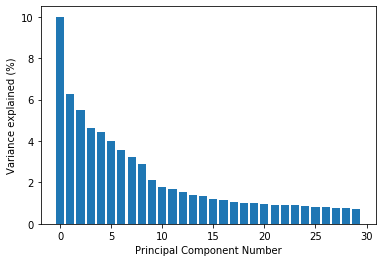

In [47]:
# Investigate the variance accounted for by each principal component.
n = 30
plt.bar([i for i in range(0,n)], pca.explained_variance_ratio_[0:n] * 100)
plt.xlabel('Principal Component Number')
plt.ylabel('Variance explained (%)')

We see that at around n = 10 we start to see significant decrease in the variance that can be explained by the PC. n = 10 could be a good cut-off point for selecting the maximum number of PCs.

Text(0, 0.5, 'Cumulative Variance explained (%)')

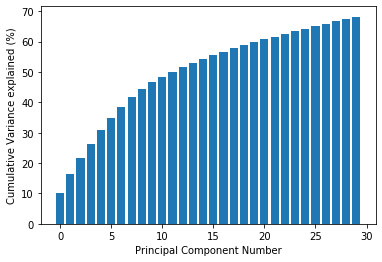

In [48]:
# Plot the cumulative sum of variance explained by the first n-th Principal Components
plt.bar([i for i in range(0,n)], np.cumsum(pca.explained_variance_ratio_[0:n] * 100))
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Variance explained (%)')

In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.
num_pc = 15
pca_15 = PCA(n_components=num_pc)
pca_15.fit(azdias_dataset_clean_imputed_scaled)
azdias_dataset_clean_pca_reduced = pca_15.fit_transform(azdias_dataset_clean_imputed_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

**Ans**: About 50% of the total variance can be explained by the first 15 principal components. We also see that after around n=15, the variance explained tends to plateau and hovers below 2%. This is not significant, which may be attributed to noise instead. Therefore, it is sufficient to retain the first 15 principal components of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_pc_feature_weight(pca_feature_weight, features, end_idx, threshold):
    """
    Prints the top i-th features based on the unit vector of a principal component
    Ignores features with weight below the threshold
    
    Args: 
        pca_weight: Unit vector of a principal component
        features: List of features of the data
        end_idx: Top i-th of features to return
    """    
    feature_idx_pc = np.argsort(np.abs(pca_feature_weight))
    for index in np.flip(feature_idx_pc)[:end_idx]:
        if abs(pca_feature_weight[index]) > threshold:
            print ("Feature: %s, Weight: %.2f " %(feature_list[index], pca_feature_weight[index]))

feature_list = azdias_dataset_clean_imputed_scaled.columns
get_pc_feature_weight(pca_15.components_[0], feature_list, 10, 0.1)

Feature: ANZ_HAUSHALTE_AKTIV, Weight: 0.43 
Feature: ANZ_PERSONEN, Weight: -0.30 
Feature: KBA13_ANZAHL_PKW, Weight: -0.23 
Feature: ANZ_HH_TITEL, Weight: 0.21 
Feature: PLZ8_BAUMAX_1.0, Weight: -0.20 
Feature: MIN_GEBAEUDEJAHR, Weight: -0.18 
Feature: CAMEO_HOUSEHOLD_WEALTH_5, Weight: 0.16 
Feature: PLZ8_ANTG4, Weight: 0.15 
Feature: CAMEO_LIFE_STAGE_1, Weight: 0.15 
Feature: LP_STATUS_FEIN_1.0, Weight: 0.14 


In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_pc_feature_weight(pca_15.components_[1], feature_list, 10, 0.1)

Feature: PRAEGENDE_JUGENDJAHRE_DECADE_6.0, Weight: -0.26 
Feature: FINANZ_SPARER, Weight: -0.25 
Feature: ZABEOTYP_3, Weight: 0.25 
Feature: FINANZ_VORSORGER, Weight: 0.22 
Feature: ALTERSKATEGORIE_GROB, Weight: 0.21 
Feature: FINANZ_ANLEGER, Weight: -0.21 
Feature: FINANZ_UNAUFFAELLIGER, Weight: -0.21 
Feature: ANZ_HH_TITEL, Weight: 0.21 
Feature: FINANZTYP_1, Weight: -0.20 
Feature: SEMIO_REL, Weight: -0.18 


In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_pc_feature_weight(pca_15.components_[2], feature_list, 10, 0.1)

Feature: ANZ_HH_TITEL, Weight: 0.60 
Feature: ANZ_TITEL, Weight: 0.49 
Feature: ANZ_PERSONEN, Weight: 0.40 
Feature: ANZ_HAUSHALTE_AKTIV, Weight: 0.29 
Feature: LP_FAMILIE_FEIN_1.0, Weight: -0.15 
Feature: KBA13_ANZAHL_PKW, Weight: 0.11 


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Ans**:

#### **1st Principal Component**

##### **Features (Positive Values)**
1. Number of households in the building 
2. Number of professional academic title holders in building
3. German CAMEO Household Wealth (Poorer Households)
4. Number of 1-2 family houses in the PLZ8 region (very high share of 1-2 family homes) 
5. German CAMEO Life Stage (Pre-Family Couples & Singles)
6. Social status (typical low-income earners)

##### **Features (Negative Values)**
1. Number of adults in household
2. Number of cars in the PLZ8 region
3. Most common building type within the PLZ8 region (mainly 1-2 family homes)
4. First year building was mentioned in the database

##### **Interpretation of the 1st PC**
The 1st PC appears to be linked to income, family size, home size, social status and life stage.

#### **2nd Principal Component**

##### **Features (Positive Values)**
1. Energy consumption typology (fair supplied)
2. Financial typology - be prepared, (1 - very high, 5 - very low)
3. Estimated age based on given name analysis (1: <30 year old, 4: > 60 year old, 9:uniformly distributed)
4. Number of professional academic title holders in building

##### **Features (Negative Values)**
1. Dominating movement of person's youth (60s)
2. Financial typology - money-saver, (1 - very high, 5 - very low)
3. Financial typology - investor, (1 - very high, 5 - very low)
4. Financial typology - inconspicuous (not fond of luxury) (1 - very high, 5 - very low)
5. Most descriptive financial type for individual (low financial interest (MINIMALIST))
6. Personality typology - religious (1 - highest affinity, 7 - lowest affinity)

##### **Interpretation of the 2nd PC**
It seems that the 2nd PC is linked to age, movement and savings and financial habits of the person.

#### **3rd Principal Component**

##### **Features (Positive Values)**
1. Number of professional academic title holders in building
2. Number of professional academic title holders in household
3. Number of adults in household
4. Number of households in the building
5. Number of cars in the PLZ8 region

##### **Features (Negative Values)**
1. Family type - single 

##### **Interpretation of the 3rd PC**

The 3rd PC seems to be linked to family type and academic status of the member of household.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
from sklearn.cluster import MiniBatchKMeans, KMeans
#Use MiniBatchKMeans to reduce computation time

N_MAX = 30
avg_clster_dist_list = []

# Over a number of different cluster counts...
for n in range(1, N_MAX + 1):
    # run k-means clustering on the data 
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=0, max_iter=200, batch_size=10000).fit(azdias_dataset_clean_pca_reduced)
    # compute the average within-cluster distances.
    avg_clster_dist = -1 * kmeans.score(azdias_dataset_clean_pca_reduced) / len(azdias_dataset_clean_pca_reduced)
    avg_clster_dist_list.append(avg_clster_dist)

Text(0, 0.5, 'Average within-cluster distance')

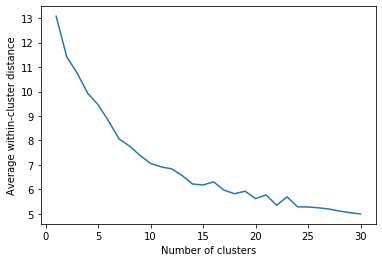

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(1, N_MAX+1), avg_clster_dist_list)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster distance')

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_azdias = KMeans(n_clusters=20, random_state=0).fit(azdias_dataset_clean_pca_reduced)

In [56]:
azdias_clusters = kmeans_azdias.predict(azdias_dataset_clean_pca_reduced)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Ans**: From the Elbow plot, we can see that the average within-cluster distance continnues to decrease, before becoming saturated around n = 20. Beyond this point, there is no significant reduction in cluster distances. We chose n = 20 as the number of clusters for segmenting the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers_dataset = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_dataset_clean = clean_data(customers_dataset.copy())
customers_dataset_clean_imputed = impute_feature(customers_dataset_clean.copy())
customers_dataset_clean_imputed_scaled = scale_feature(customers_dataset_clean_imputed.copy())

Number of outlier columns = 5
Percentage of outlier columns = 5.882353 %
Row Outlier Threshold : 0.415780
Feature (mean, variance): ANZ_PERSONEN ([2.27470113], [1.94318404])
Feature (mean, variance): ANZ_TITEL ([0.02039269], [0.02322])
Feature (mean, variance): ANZ_HAUSHALTE_AKTIV ([5.05321845], [203.28787421])
Feature (mean, variance): ANZ_HH_TITEL ([0.0674134], [0.29156874])
Feature (mean, variance): MIN_GEBAEUDEJAHR ([1993.05665902], [9.43933106])
Feature (mean, variance): KBA13_ANZAHL_PKW ([667.23121585], [114232.66444131])


In [59]:
customers_dataset_clean_pca_reduced = pca_15.fit_transform(customers_dataset_clean_imputed_scaled)
customers_clusters = kmeans_azdias.predict(customers_dataset_clean_pca_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

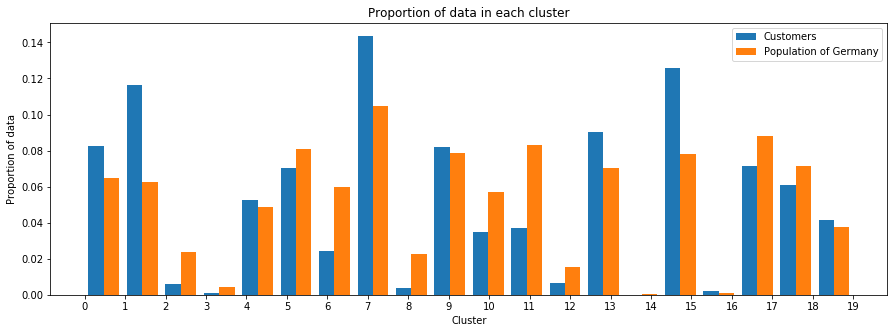

In [60]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure(figsize=(15, 5))
plt.hist([customers_clusters, azdias_clusters], bins=20, density=True)
plt.ylabel("Proportion of data")
plt.xlabel("Cluster")
plt.title("Proportion of data in each cluster")
ax = plt.xticks([i for i in range (0,20)])
plt.legend(['Customers', 'Population of Germany'])

In [205]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
def plot_hist_population_cluster(azdias_dataset, azdias_dataset_clean_imputed, cluster_kmeans, cluster_n, feature_list):
    """
    Plot the histograms of features for `cluster_n` of the population dataset
    using the original dataset (before features were encoded)
    
    Args: 
        azdias_dataset: Population dataset (before encoding)
        azdias_dataset_clean_imputed: Population dataset (after encoding)
        kmeans: KMeans clusters of the population dataset
        cluster_n: Choice of cluster
        feature_list: List of features for plotting
    """ 
    fig = plt.figure(figsize=(20, 10))
    n_subplot = len(feature_list)
    n_rows = 2
    index = 0
    for feature in feature_list:
        index += 1
        ax = fig.add_subplot(n_rows,n_subplot/n_rows,index)
        df_cluster_n = azdias_dataset_clean_imputed.loc[cluster_kmeans == cluster_n]
        sns.countplot(azdias_dataset.loc[df_cluster_n.index.values, feature], ax=ax)

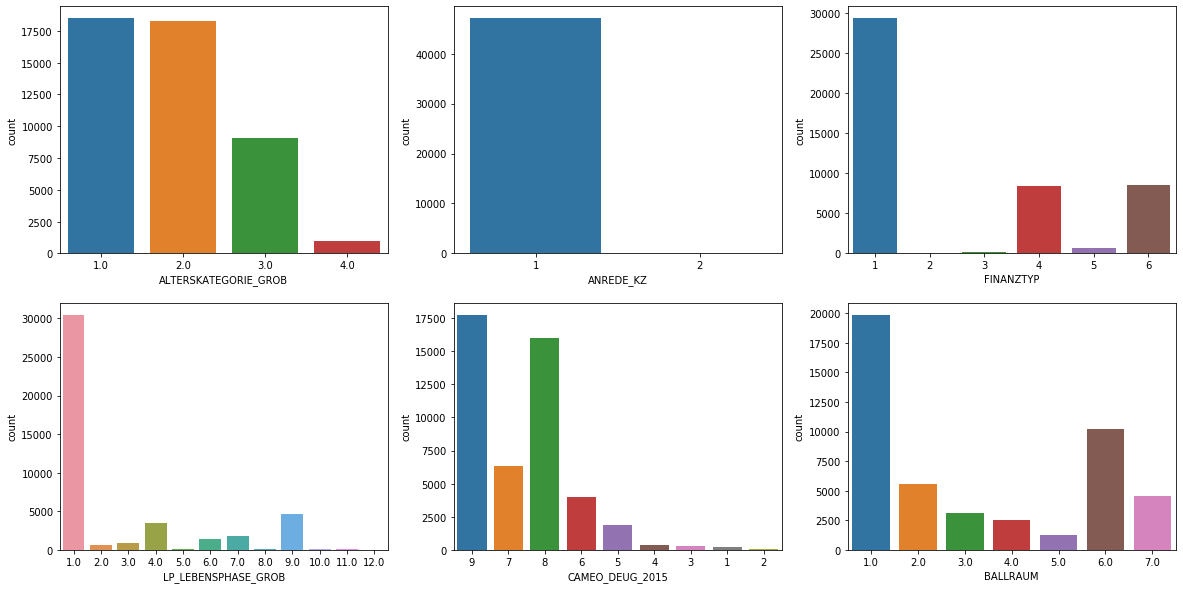

In [214]:
feature_list = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZTYP', 'LP_LEBENSPHASE_GROB', 'CAMEO_DEUG_2015', 'BALLRAUM']
plot_hist_population_cluster(azdias_dataset, azdias_dataset_clean_imputed, azdias_clusters, 1, feature_list)

Cluster **1** is overrepresented in the customer data as compared to the general population. Looking at the histograms for selected features, the dominant characteristics of this cluster are:

* < 30 years old or 30 - 45 years old
* male
* low financial interest 
* single low-income and average earners of younger age
* working class
* mostly live in less than 10 km away from urban center

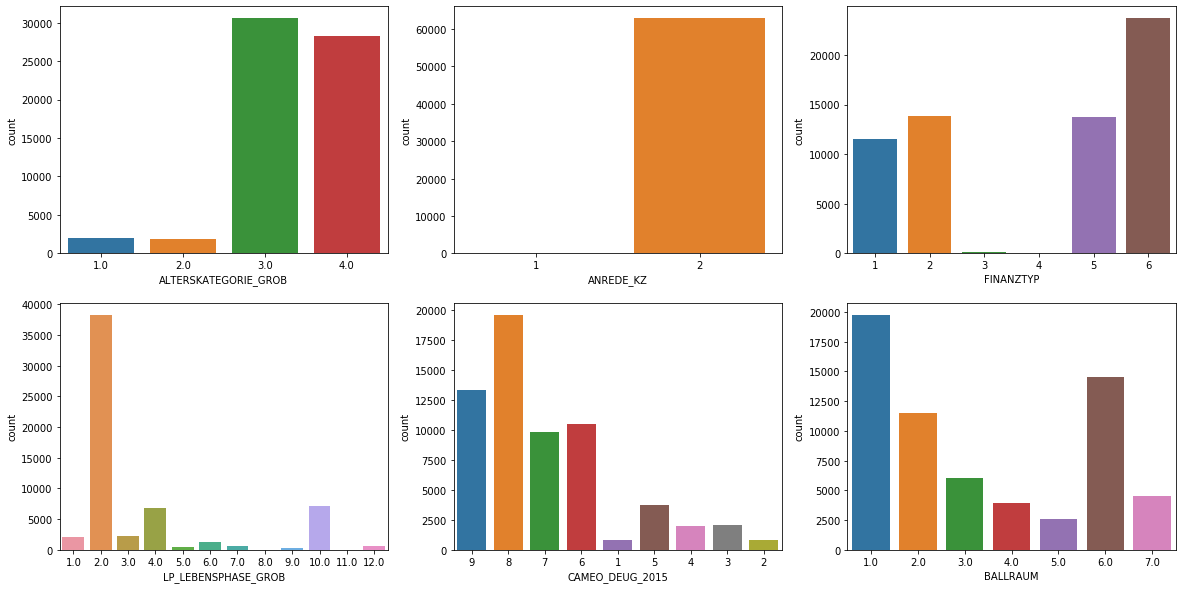

In [215]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
feature_list = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZTYP', 'LP_LEBENSPHASE_GROB', 'CAMEO_DEUG_2015', 'BALLRAUM']
plot_hist_population_cluster(azdias_dataset, azdias_dataset_clean_imputed, azdias_clusters, 11, feature_list)

Cluster **11** is underrepresented in the customer data as compared to the general population.

* 46 - 60 years old or > 60 years old
* female
* mostly inconspicuous consumer, or money-saver or investor
* single low-income and average earners of higher age
* working class
* mostly live in less than 10 km away from urban centres, but there's also a good mix of those who live further away

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Ans**: Based on the cluster analysis above, we can roughly say that the more popular consumers are young males that are relatively higher earners living and working near urban areas. The less popular segment are the older females  with average earning power, most of whom are single and working class. This group of people also tend to live near urban-centres, with a good mix of those living further away from urban centres, especially if compared to the younger male population segment.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.